# COVID CLASSIFICATION

#### Install tensorflow

In [1]:
pip install tensorflow

#### Import libraries

In [2]:
import random
import numpy as np
import pandas as pd
import os
import sys
import shutil
import csv
from posixpath import join
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input

#### Directories

In [3]:
#Base directories
base_dir = './dataset'
train_dir = join(base_dir, 'train')
test_dir = join(base_dir, 'test')
#Directories for train
train_covid_dir = join(train_dir, 'covid')
train_normal_dir = join(train_dir, 'normal')
train_pneumonia_dir = join(train_dir, 'pneumonia')
# Directory for test
test_covid_dir = join(test_dir, 'covid')
test_normal_dir = join(test_dir, 'normal')
test_pneumonia_dir = join(test_dir, 'pneumonia')

#### Split data into train and test folders

In [4]:
classes_dir = ['covid', 'normal', 'pneumonia']
root_dir = './dataset/'
test_ratio = 0.20

total_test_img = 0
total_train_img = 0 

for cls in classes_dir:
    os.makedirs(root_dir +'train/' + cls)
    os.makedirs(root_dir +'test/' + cls)

    src = root_dir + cls

    all_file_names = os.listdir(src)
    np.random.shuffle(all_file_names)
    train_file_names, test_file_names = np.split(np.array(all_file_names),  [int(len(all_file_names)* (1 - test_ratio))])

    train_file_names = [src + '/'+ name for name in train_file_names.tolist()]
    test_file_names = [src + '/' + name for name in test_file_names.tolist()]
    
    total_test_img += len(test_file_names)
    total_train_img += len(train_file_names)

    print('Total images', cls, ":", len(all_file_names))
    print('Training', cls, ":", len(train_file_names))
    print('Testing', cls, ":", len(test_file_names))

    for name in train_file_names:
        shutil.copy(name, root_dir +'train/' + cls)

    for name in test_file_names:
        shutil.copy(name, root_dir +'test/' + cls)

Total images covid : 11520
Training covid : 9216
Testing covid : 2304
Total images normal : 10728
Training normal : 8582
Testing normal : 2146
Total images pneumonia : 10578
Training pneumonia : 8462
Testing pneumonia : 2116


#### Show images

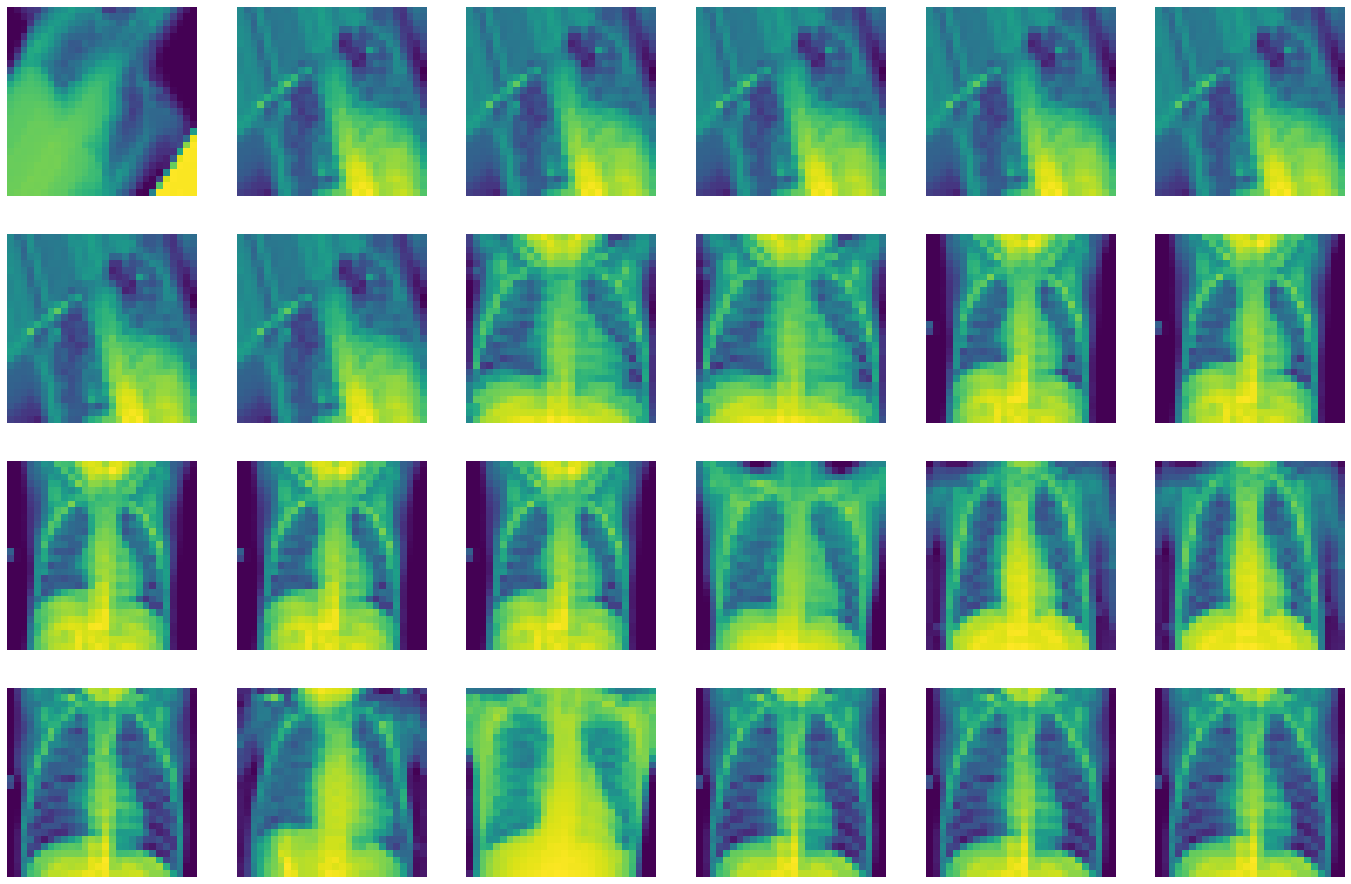

In [5]:
nrows = 4
ncols = 6
pic_index = 100

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

train_covid_fnames = os.listdir(train_covid_dir)
train_normal_fnames = os.listdir(train_normal_dir)
train_pneumonia_fnames = os.listdir(train_pneumonia_dir)

train_covid_pix = [os.path.join(train_covid_dir, fname) for fname in train_covid_fnames[ pic_index-8:pic_index]]
train_normal_pix = [os.path.join(train_normal_dir, fname) for fname in train_normal_fnames[ pic_index-8:pic_index]]
train_pneumonia_pix = [os.path.join(train_pneumonia_dir, fname) for fname in train_pneumonia_fnames[ pic_index-8:pic_index] ]

for i, img_path in enumerate(train_covid_pix + train_normal_pix + train_pneumonia_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

#### Test and Train generator

In [6]:
batch_size = 20
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'categorical', target_size = (32, 32))
test_generator = test_datagen.flow_from_directory( test_dir,  batch_size = 20, class_mode = 'categorical', target_size = (32, 32), shuffle = False)

Found 26260 images belonging to 3 classes.
Found 6566 images belonging to 3 classes.


#### To print useful information

In [7]:
def print_info(model_hist):
    print("Training Accuracy    :", model_hist.history['acc'][-1] )
    print("Training Loss        :", model_hist.history['loss'][-1])
    print("Test Accuracy        :", model_hist.history['val_acc'][-1] )
    print("Test Loss            :", model_hist.history['val_loss'][-1])

In [8]:
def confusion_matrix_report(model, test_gen):
    Y_pred = model.predict(test_gen, total_test_img // batch_size+1)
    y_pred = np.argmax(Y_pred, axis=1)

    print('Confusion matrix')
    conf_matrix = confusion_matrix(test_gen.classes, y_pred)
    cm = np.array2string(conf_matrix)
    print(conf_matrix)
    print("")

    print('Classification report')
    class_report = classification_report(test_gen.classes, y_pred, target_names=classes_dir)
    print(class_report)

## VGG16 

In [9]:
def load_vgg_model_tuned():    
    from tensorflow.keras.applications.vgg16 import VGG16

    base_model = VGG16(input_shape = (32, 32, 3),
    include_top = False,
    weights = 'imagenet')

    for layer in base_model.layers:
        layer.trainable = False
    
    x = layers.Flatten()(base_model.output)

    x = layers.Dense(512, use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = layers.Dense(3, use_bias = False) (x)
    x = BatchNormalization()(x)
    x = Activation('softmax')(x)


    model = tf.keras.models.Model(base_model.input, x)
    loss = tf.keras.losses.CategoricalCrossentropy(
        from_logits=False,
        label_smoothing=0,
        reduction="auto",
        name="categorical_crossentropy",
    )
    
    opt = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)

    model.compile(optimizer = opt, loss = loss, metrics = ['acc'])
    
    return model

In [12]:
vgg_model = load_vgg_model_tuned()

In [13]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [14]:
vgg_hist = vgg_model.fit(train_generator, validation_data = test_generator, steps_per_epoch = 100, epochs = 10)

Epoch 1/10
100/100 [==============================] - 14s 132ms/step - loss: 0.6036 - acc: 0.7665 - val_loss: 0.7366 - val_acc: 0.8061
Epoch 2/10
100/100 [==============================] - 17s 168ms/step - loss: 0.4907 - acc: 0.8340 - val_loss: 0.6150 - val_acc: 0.7696
Epoch 3/10
100/100 [==============================] - 16s 163ms/step - loss: 0.4535 - acc: 0.8495 - val_loss: 0.6175 - val_acc: 0.6983
Epoch 4/10
100/100 [==============================] - 16s 166ms/step - loss: 0.4341 - acc: 0.8530 - val_loss: 0.4457 - val_acc: 0.8320
Epoch 5/10
100/100 [==============================] - 16s 163ms/step - loss: 0.3922 - acc: 0.8720 - val_loss: 0.5259 - val_acc: 0.7518
Epoch 6/10
100/100 [==============================] - 17s 168ms/step - loss: 0.3879 - acc: 0.8650 - val_loss: 0.2952 - val_acc: 0.9077
Epoch 7/10
100/100 [==============================] - 17s 166ms/step - loss: 0.3853 - acc: 0.8655 - val_loss: 0.2677 - val_acc: 0.9196
Epoch 8/10
100/100 [==============================] - 1

In [15]:
print_info(vgg_hist)

Training Accuracy    : 0.8654999732971191
Training Loss        : 0.37313348054885864
Test Accuracy        : 0.8012488484382629
Test Loss            : 0.4360736906528473


In [16]:
confusion_matrix_report(vgg_model, test_generator)

Confusion matrix
[[1913  391    0]
 [   0 2130   16]
 [   0  898 1218]]

Classification report
              precision    recall  f1-score   support

       covid       1.00      0.83      0.91      2304
      normal       0.62      0.99      0.77      2146
   pneumonia       0.99      0.58      0.73      2116

    accuracy                           0.80      6566
   macro avg       0.87      0.80      0.80      6566
weighted avg       0.87      0.80      0.80      6566



# Conv2D

In [17]:
def create_conv_net():
    input_rgb = Input(shape = (28, 28, 3), dtype = 'float32')
    x = Conv2D(filters = 32,
               kernel_size = (3, 3),
               strides = (1, 1),
               use_bias = False)(input_rgb)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)    
    
    x = MaxPooling2D(pool_size = (2, 2))(x)
    
    
    x = Conv2D(filters = 64,
              kernel_size = (3, 3),
              strides = (1, 1),
              use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)    
    
    x = Conv2D(filters = 128,
              kernel_size = (3, 3),
              strides = (1, 1),
              use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    
    x = Conv2D(filters = 256,
              kernel_size = (3, 3),
              strides = (1, 1),
              use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)   
    
    x = Flatten()(x)
    
    x = Dense(512, use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(3, use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Activation('softmax')(x)
    
    opt = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
    model = Model(inputs = [input_rgb], outputs = [x])
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['acc'])
    return model

In [18]:
conv_model = create_conv_net()

In [19]:
train_conv_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'categorical', target_size = (28, 28))
test_conv_generator = test_datagen.flow_from_directory( test_dir,  batch_size = 20, class_mode = 'categorical', target_size = (28, 28), shuffle = False)

Found 26260 images belonging to 3 classes.
Found 6566 images belonging to 3 classes.


In [20]:
conv_history = conv_model.fit(train_conv_generator, validation_data = test_conv_generator, steps_per_epoch = 100, epochs = 10)

Epoch 1/10
100/100 [==============================] - 7s 64ms/step - loss: 0.6784 - acc: 0.7330 - val_loss: 1.6769 - val_acc: 0.3447
Epoch 2/10
100/100 [==============================] - 6s 63ms/step - loss: 0.5413 - acc: 0.8020 - val_loss: 2.2327 - val_acc: 0.3920
Epoch 3/10
100/100 [==============================] - 6s 64ms/step - loss: 0.4710 - acc: 0.8470 - val_loss: 1.4071 - val_acc: 0.5635
Epoch 4/10
100/100 [==============================] - 6s 64ms/step - loss: 0.4452 - acc: 0.8490 - val_loss: 1.2168 - val_acc: 0.5775
Epoch 5/10
100/100 [==============================] - 7s 67ms/step - loss: 0.4277 - acc: 0.8555 - val_loss: 0.7761 - val_acc: 0.6875
Epoch 6/10
100/100 [==============================] - 7s 68ms/step - loss: 0.4041 - acc: 0.8675 - val_loss: 0.4484 - val_acc: 0.8363
Epoch 7/10
100/100 [==============================] - 6s 63ms/step - loss: 0.3833 - acc: 0.8705 - val_loss: 2.3760 - val_acc: 0.4846
Epoch 8/10
100/100 [==============================] - 6s 62ms/step - 

In [21]:
print_info(conv_history)

Training Accuracy    : 0.878000020980835
Training Loss        : 0.34767529368400574
Test Accuracy        : 0.6722509860992432
Test Loss            : 0.8247098326683044


In [22]:
confusion_matrix_report(conv_model, test_conv_generator)

Confusion matrix
[[1527  777    0]
 [   6 2129   11]
 [  21 1337  758]]

Classification report
              precision    recall  f1-score   support

       covid       0.98      0.66      0.79      2304
      normal       0.50      0.99      0.67      2146
   pneumonia       0.99      0.36      0.53      2116

    accuracy                           0.67      6566
   macro avg       0.82      0.67      0.66      6566
weighted avg       0.83      0.67      0.66      6566



# ResNet50

#### Model

In [23]:
resnet_model = tf.keras.Sequential()
resnet_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max', input_shape = (32, 32, 3)))

In [24]:
for layer in resnet_model.layers:
    layer.trainable = False

In [25]:
resnet_model.add(BatchNormalization())
resnet_model.add(Flatten())
resnet_model.add(Dense(256, activation = "relu"))
resnet_model.add(Dense(3, activation='softmax'))

In [26]:
resnet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])

In [27]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_8 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 24,121,219
Trainable params: 529,411
Non-trainable params: 23,591,808
______________________________________

In [28]:
resnet_history = resnet_model.fit(train_generator, validation_data = test_generator, steps_per_epoch = 100, epochs = 50)

Epoch 1/50
100/100 [==============================] - 13s 109ms/step - loss: 0.8848 - acc: 0.5840 - val_loss: 1.1362 - val_acc: 0.3707
Epoch 2/50
100/100 [==============================] - 10s 105ms/step - loss: 0.7273 - acc: 0.6825 - val_loss: 0.7807 - val_acc: 0.6413
Epoch 3/50
100/100 [==============================] - 12s 117ms/step - loss: 0.6876 - acc: 0.6915 - val_loss: 0.6108 - val_acc: 0.7671
Epoch 4/50
100/100 [==============================] - 11s 115ms/step - loss: 0.6640 - acc: 0.7130 - val_loss: 0.5210 - val_acc: 0.7924
Epoch 5/50
100/100 [==============================] - 12s 120ms/step - loss: 0.6397 - acc: 0.7235 - val_loss: 0.5285 - val_acc: 0.7551
Epoch 6/50
100/100 [==============================] - 11s 115ms/step - loss: 0.6084 - acc: 0.7490 - val_loss: 0.4808 - val_acc: 0.7976
Epoch 7/50
100/100 [==============================] - 12s 117ms/step - loss: 0.6175 - acc: 0.7360 - val_loss: 0.4925 - val_acc: 0.7819
Epoch 8/50
100/100 [==============================] - 1

In [29]:
print_info(resnet_history)

Training Accuracy    : 0.8080000281333923
Training Loss        : 0.4662344753742218
Test Accuracy        : 0.8437404632568359
Test Loss            : 0.372641921043396


In [30]:
confusion_matrix_report(resnet_model, test_generator)

Confusion matrix
[[2010  226   68]
 [  22 2094   30]
 [  27  653 1436]]

Classification report
              precision    recall  f1-score   support

       covid       0.98      0.87      0.92      2304
      normal       0.70      0.98      0.82      2146
   pneumonia       0.94      0.68      0.79      2116

    accuracy                           0.84      6566
   macro avg       0.87      0.84      0.84      6566
weighted avg       0.87      0.84      0.84      6566

